# Evaluating the Trained Channel Estimator
Now that we have a trained model, we can use it in the communication pipeline and compare its performance with baselines. In this case we compare it with perfect channel estimation and **NeoRadium**'s Least-Square channel estimation method.

The following diagram shows the pipeline used for evaluation of our deep-learning-based channel estimator.

![Evaluation-Pipeline](EvalPipeline.png)

So, lets get started by importing some **NeoRadium** and [Fireball](https://github.com/InterDigitalInc/Fireball) modules.

In [1]:
import numpy as np
import scipy.io
import time
import matplotlib.pyplot as plt

from neoradium import Carrier, PDSCH, CdlChannel, AntennaPanel, Grid, random

from fireball import Model, Block
from fireball.datasets.base import BaseDSet

## Load the trained mode
Here we use the Fireball's [makeFromFile](https://interdigitalinc.github.io/Fireball/html/source/model.html#fireball.model.Model.makeFromFile) function to load the model trained and saved in the [previous step](MLChestTrain.ipynb).

In [2]:
model = Model.makeFromFile("Models/ChEstResNet.fbm", gpus="0")

model.printLayersInfo()      # Print layers
print("Model Complexity:",'{:,} flops'.format(model.getFlops()))  # Print model complexity
model.initSession()          # Initialize the TensorFlow session for inference



Reading from "Models/ChEstResNet.fbm" ... Done.
Creating the fireball model "ChanEst" ... Done.

Scope            InShape       Comments                 OutShape      Activ.   Post Act.        # of Params
---------------  ------------  -----------------------  ------------  -------  ---------------  -----------
IN_TENSOR        14 612 2      Tensor Shape: 14x612x2   14 612 2      None                      0          
S1_L1_RES2       14 612 2      2 Paths, 8 layers        14 612 64     ReLU                      27,328     
S1_L2_RES1       14 612 64     2 Paths, 7 layers        14 612 64     ReLU                      7,904      
S2_L1_CONV       14 612 64     KSP: 3 1 s               14 612 2      None     L2               1,154      
OUT_REG          14 612 2                               14 612 2      None                      0          
---------------------------------------------------------------------------------------------------------
                                        

## ``mlChanEst`` function
The ``mlChanEst`` function in the following cell receives the DMRS information, the received resource grid, and the trained model as input. It first calculates the channel estimates at the pilot locations using LS method and then converts these estimates to a set of ``L x K`` complex matrixes that are fed to the model for inference. (``L`` is the number of OFDM symbols per slot and ``K`` is the number of subcarriers) 

The model outputs another set of ``L x K`` matrixes which contain the predicted channel information. These matrixes are then re-packaged as a 4-D complex numpy array that is returned as the estimated channel.

In [3]:
def mlChanEst(dmrs, rxGrid, model):
    rsGrid = rxGrid.bwp.createGrid( len(dmrs.pdsch.portSet) )   # Create an empty resource grid
    dmrs.populateGrid(rsGrid)                                   # Populate the grid with DMRS values
    rsIndexes = rsGrid.getReIndexes("DMRS")                     # This contains the locations of DMRS values
  
    rr, ll, kk = rxGrid.shape           # Number of RX antenna, Number of symbols, Number of subcarriers
    pp, ll2, kk2 = rsGrid.shape         # Number of Ports (From DMRS)
    if (ll!=ll2) or (kk!=kk2): raise ValueError("The Gird size (%dx%d) does not match the DMRs (%dx%d)."%(ll,kk,ll2,kk2))

    modelIn = []
    for p in range(pp):                             # For each DMRS port (i.e. each layer)
        portLs = rsIndexes[1][(rsIndexes[0]==p)]    # Indexes of symbols containing pilots in this port
        portKs = rsIndexes[2][(rsIndexes[0]==p)]    # Indexes of subcarriers containing pilots in this port

        ls = np.unique(portLs)                      # Unique Indexes of symbols containing pilots in this port
        ks = portKs[portLs==ls[0]]                  # Unique Indexes of subcarriers containing pilots in this port
        numLs, numKs = len(ls), len(ks)             # Number of OFDM symbols and number of subcarriers

        pilotValues = rsGrid[p,ls,:][:,ks]                              # Pilot values in this port
        rxValues = rxGrid.grid[:,ls,:][:,:,ks]                          # Received values for pilot signals
        hEst = np.transpose(rxValues/pilotValues[None,:,:], (1,2,0))    # Channel estimates at pilot locations

        
        for r in range(rr):                                         # For each receiver antenna
            inH = np.zeros(rxGrid.shape[1:]+(2,), dtype=np.float64) # Create one 3D matrix with all zeros
            for li,l in enumerate(ls):
                inH[l,ks,0] = hEst[li,:,r].real             # Set the LS estimates at pilot location (Real)
                inH[l,ks,1] = hEst[li,:,r].imag             # Set the LS estimates at pilot location (Imaginary)
            modelIn += [ inH ]

    modelIn = np.stack(modelIn)                             # Package all inputs as a batch
    modelOut = model.inferBatch(modelIn)                    # Run inference for the whole batch
    estChan = np.transpose( modelOut.reshape((pp,rr)+modelOut.shape[1:]), (2,3,1,0,4) )  # Convert to a 5-D tensor
    estChan = estChan[...,0] + 1j*estChan[...,1]            # Convert to a 4-D complex tensor
    return estChan


## Evaluation Pipeline
The following cell implements the evaluation pipeline as shown above. It runs the pipeline 3 times with perfect, ML, and LS channel estimation and prints the results at the end. As it can be seen the ML-based channel estimation performs better than LS method which is based on interpolation.


Simulating end-to-end for "16QAM", with "Perfect" channel estimation, in time domain.
SNR(dB)   Total Bits   Bit Errors   BER(%)   time(Sec.)
-------   ----------   ----------   ------   ----------
    5       2545920      1036799     40.72      6.80
   10       2545920       850716     33.41      6.95
   15       2545920       606267     23.81      7.02
   20       2545920       350625     13.77      6.81
   25       2545920       145817      5.73      6.83

Simulating end-to-end for "16QAM", with "ML" channel estimation, in time domain.
SNR(dB)   Total Bits   Bit Errors   BER(%)   time(Sec.)
-------   ----------   ----------   ------   ----------
    5       2545920      1093175     42.94      7.42
   10       2545920       894557     35.14      7.24
   15       2545920       638622     25.08      7.25
   20       2545920       388298     15.25      7.67
   25       2545920       191185      7.51      7.64

Simulating end-to-end for "16QAM", with "LS" channel estimation, in time dom

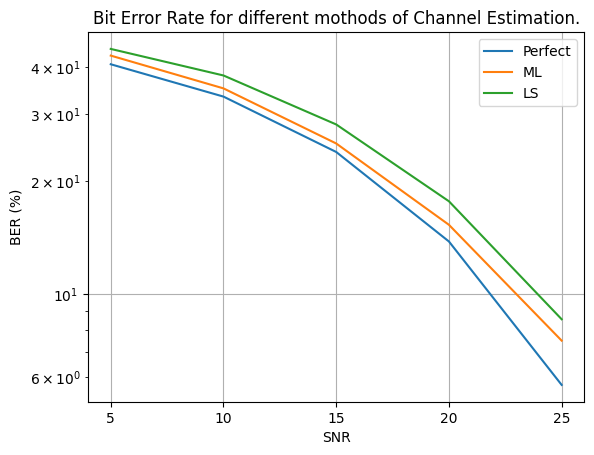

In [4]:
numFrames = 2                               # Number of time-domain frames
snrDbs = [5,10,15,20,25]                    # SNR values (in dB) for which we want to evaluate the model
freqDomain = False                          # Set to True to apply channel in frequency domain

carrier = Carrier(numRbs=51, spacing=30)    # Create a carrier with 51 RBs and 30KHz subcarrier spacing
bwp = carrier.curBwp                        # The only bandwidth part in the carrier

# Create a PDSCH object
pdsch = PDSCH(bwp, interleavingBundleSize=0, numLayers=2, nID=carrier.cellId, modulation="16QAM")
pdsch.setDMRS(prgSize=0, configType=2, additionalPos=2)     # Specify the DMRS configuration

numSlots = bwp.slotsPerFrame*numFrames                      # Total number of slots
results = {}                                                # Dictionary to save the results

for chanEstMethod in ["Perfect", "ML", "LS"]:               # Three different channel estimation methods
    results[chanEstMethod] = {}
    print("\nSimulating end-to-end for \"%s\", with \"%s\" channel estimation, in %s domain."%
          ("16QAM", chanEstMethod, "frequency" if freqDomain else "time"))
    print("SNR(dB)   Total Bits   Bit Errors   BER(%)   time(Sec.)")
    print("-------   ----------   ----------   ------   ----------")
    for snrDb in snrDbs:                                # For each SNR value in snrDbs
        random.setSeed(123)                             # Making the results reproducible for each SNR
        t0 = time.time()                                # Start time for each SNR
        carrier.slotNo = 0

        # Creating a CdlChannel object
        channel = CdlChannel('C', delaySpread=300, carrierFreq=4e9, dopplerShift=5,
                             txAntenna = AntennaPanel([2,2], polarization="x"),  # 8 TX antenna
                             rxAntenna = AntennaPanel([1,1], polarization="+"),  # 2 RX antenna
                             seed = 123,
                             timing = "nearest")  

        bitErrors = 0
        totalBits = 0

        for slotNo in range(numSlots):
            grid = pdsch.getGrid()                      # Create a resource grid populated with DMRS
            numBits = pdsch.getBitSizes(grid)[0]        # Number of bits available in the resource grid
            txBits = random.bits(numBits)               # Create random binary data

            pdsch.populateGrid(grid, txBits)            # Map/modulate the data to the resource grid

            # Store the indexes of the PDSCH data in pdschIndexes to be used later.
            pdschIndexes = pdsch.getReIndexes(grid, "PDSCH")   

            # Getting the Precoding Matrix, and precoding the resource grid
            channelMatrix = channel.getChannelMatrix(bwp)           # Get the channel matrix
            precoder = pdsch.getPrecodingMatrix(channelMatrix)      # Get the precoder matrix from PDSCH object
            precodedGrid = grid.precode(precoder)                   # Perform the precoding

            if freqDomain:
                rxGrid = precodedGrid.applyChannel(channelMatrix)   # Apply the channel in frequency domain
                rxGrid = rxGrid.addNoise(snrDb=snrDb)               # Add noise
            else:
                txWaveform = precodedGrid.ofdmModulate()            # OFDM Modulation
                maxDelay = channel.getMaxDelay()                    # Get the max. channel delay
                txWaveform = txWaveform.pad(maxDelay)               # Pad with zeros
                rxWaveform = channel.applyToSignal(txWaveform)      # Apply channel in time domain
                noisyRxWaveform = rxWaveform.addNoise(snrDb=snrDb, nFFT=bwp.nFFT)  # Add noise
                offset = channel.getTimingOffset()                  # Get timing info for synchronization
                syncedWaveform = noisyRxWaveform.sync(offset)       # Synchronization
                rxGrid = syncedWaveform.ofdmDemodulate(bwp)         # OFDM demodulation
                
            if chanEstMethod == "Perfect":                          # Perfect Channel Estimation
                estChannelMatrix = channelMatrix @ precoder[None,...]
            elif chanEstMethod == "LS":                             # LS + Interpolation Channel Estimation
                estChannelMatrix, noiseEst = rxGrid.estimateChannelLS(pdsch.dmrs, polarInt=False, 
                                                                      kernel='linear')
            elif chanEstMethod == "ML":                             # ML-Based Channel Estimation
                estChannelMatrix = mlChanEst(pdsch.dmrs, rxGrid, model)
            else: assert(0)

            eqGrid, llrScales = rxGrid.equalize(estChannelMatrix)           # Equalization

            rxBits = pdsch.getHardBitsFromGrid(eqGrid, pdschIndexes)[0]     # Demodulation
            bitErrors += np.abs(rxBits-txBits).sum()                        # Calculating number of bit errors
            totalBits += numBits
            print("\r  %3d      %8d     %8d    %6.2f    %6.2f"%(snrDb, totalBits, bitErrors, 
                                                                bitErrors*100/totalBits,time.time()-t0),end='')

            carrier.goNext()                        # Prepare the carrier object for the next slot
            channel.goNext()                        # Prepare the channel model for the next slot

        dt = time.time()-t0                         # Total time for this SNR
        results[chanEstMethod][snrDb] = {"totalBits":totalBits, 
                                         "bitErrors":bitErrors, 
                                         "BER":      bitErrors*100/totalBits,
                                         "Time":     dt}
        print("\r  %3d      %8d     %8d    %6.2f    %6.2f"%(snrDb, totalBits, bitErrors, 
                                                        bitErrors*100/totalBits, dt))
    
# Compare the results in a plot:
for i,chanEstMethod in enumerate(['Perfect', 'ML', 'LS']):
    bers = [results[chanEstMethod][snrDb]["BER"] for snrDb in snrDbs]
    plt.plot(snrDbs, bers, label=chanEstMethod)
plt.legend()
plt.title("Bit Error Rate for different mothods of Channel Estimation.");
plt.grid()
plt.xlabel("SNR")
plt.xticks(snrDbs)
plt.ylabel("BER (%)")
plt.yscale('log')
plt.show()